## **Experiments conducted on FCN model with Adam Optimizer with following hyperparameters:<br>**
Learning rate: 0.0001 <br>
Batch Size = 20<br>
Epochs = 200<br>



### Importing all necessary libraries

In [ ]:
from zipfile import ZipFile
import torchvision
import os
from scipy.io import loadmat
from sklearn.model_selection import StratifiedShuffleSplit
import collections
import numpy as np
from torch.utils.data import Dataset,DataLoader
from torchvision.models.segmentation import fcn_resnet50
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision.transforms as T
import matplotlib
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F


### Mounting the google drive to import dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# os.listdir("drive/MyDrive")

Mounted at /content/drive


### Extracting dataset from zip file

In [ ]:
# specifying the zip file name
file_name = "underwater_sem_seg.zip"
with ZipFile("drive/MyDrive/underwater_sem_seg.zip", 'r') as zip:
    # zip.printdir()
    print('Extracting all the files now...')
    zip.extractall()
    print('Done!')

Extracting all the files now...
Done!


### Storing the images, groundtruth and classes in the dataset into 3 seperate lists called images, imclasses, masks.

In [ ]:
root = "underwater_sem_seg/dataset"

entries = os.listdir(root)
entries.remove("indices_files")
entries.remove('.DS_Store')
print(entries)
folders = [root+"/"+i for i in entries[:]]
print(folders)
# entries = os.listdir(folders[0])
# print(entries)
images = []
masks = []
imclasses = []
for folder in folders:
    entries = os.listdir(folder)
    for image_data in entries:
#         print(folder+"/"+image_data)
        mat = loadmat(folder+"/"+image_data)
        # print(mat)
        images.append(np.asarray(mat["image_array"]))
        imclasses.append(mat["class"])
        masks.append(np.asarray(mat["mask_array"]))
        # images.append((imclass,image,mask_array))
    # break


['whale_sem_seg_gt', 'nudibranch_sem_seg_gt', 'frog_sem_seg_gt', 'seahorse_sem_seg_gt', 'polar_bear_sem_seg_gt', 'penguin_sem_seg_gt', 'crocodile_sem_seg_gt', 'crab_sem_seg_gt', 'turtle_sem_seg_gt', 'dolphin_sem_seg_gt', 'nettles_sem_seg_gt', 'octopus_sem_seg_gt', 'shark_sem_seg_gt', 'otter_sem_seg_gt', 'sea_anemone_sem_seg_gt', 'sea_urchin_sem_seg_gt', 'seal_sem_seg_gt', 'shrimp_sem_seg_gt', 'squid_sem_seg_gt', 'stingray_sem_seg_gt', 'star_fish_sem_seg_gt']
['underwater_sem_seg/dataset/whale_sem_seg_gt', 'underwater_sem_seg/dataset/nudibranch_sem_seg_gt', 'underwater_sem_seg/dataset/frog_sem_seg_gt', 'underwater_sem_seg/dataset/seahorse_sem_seg_gt', 'underwater_sem_seg/dataset/polar_bear_sem_seg_gt', 'underwater_sem_seg/dataset/penguin_sem_seg_gt', 'underwater_sem_seg/dataset/crocodile_sem_seg_gt', 'underwater_sem_seg/dataset/crab_sem_seg_gt', 'underwater_sem_seg/dataset/turtle_sem_seg_gt', 'underwater_sem_seg/dataset/dolphin_sem_seg_gt', 'underwater_sem_seg/dataset/nettles_sem_seg_gt

### Train-test splitting of dataset.<br>
We are using stratified shuffle split to split the data into tranining and validation sets.

In [ ]:

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.1)

for train_index, test_index in split.split(images,imclasses):
    print(train_index,test_index)
    images_train = [images[i] for i in train_index]
    classes_train = [imclasses[i] for i in train_index]
    masks_train = [masks[i] for i in train_index]

    images_test = [images[i] for i in test_index]
    classes_test = [imclasses[i] for i in test_index]
    masks_test = [masks[i] for i in test_index]

print(len(images_train),len(images_test))

[110 503 258 347  81 196  78 225 172 168 269  41 248 456 410 261 121  45
 460 409 370  26   3 348  22 197 332  40 245  91 362 190 284   9 518 335
 257 273 117 272 102 560 295 341 408  99 136 109 330 131 288 402  97 313
 445 558 508  53  68  84  52 343 176 463 538 547 435 517  31 289  72   2
  71 513 241 564 146  36 449 566  74  13 150 218 442 544  51 214 119 327
 570 476 322  25  10  46 191 100 161 412 126 363 505 355  29 551 415 482
 342 325  37 385 169 545  86  62 425 238 132 104 520  73 287 165 387 304
 310 130 275 264 156 368 350  12 391 467 145  67 380 552  88 209 254 563
  54 549 366  61 317 283 137 174 521 278  95 396 352 397 446 403 451 375
 164 125 469 466 177 496 298 500 428 528 167 492 337 353 263 434 360 510
 234  87 276 235 574  19 438  55 253 324 120 316 478 323  16 108 303 189
 173 511 471 523 140 114  21 395 398 302 427 301 413 226 436 107 369 424
 418 148 536 179 291 388 540 345 373 213 356  32 515  44 400 187  76 565
 306 437 554 519 490 141 162 285 186 453  77 256 29

### Data Augmentation
As our data size is not large, we are augmenting some of the images in the training data. 
Following are the operations performed while augmenting images:
1.	Horizontal flip (on random 200 images of training data) 
2.	Shifting to right by 20 pixels (on random 200 images of training data) 
3.	Shifting to left by 20 pixels (on random 100 images of training data) 
4.	Shifting to up by 20 pixels (on random 100 images of training data)
5.	Shifting to down by 20 pixels (on random 100 images of training data)

We have reffered a [link](https://medium.com/@schatty/image-augmentation-in-numpy-the-spell-is-simple-but-quite-unbreakable-e1af57bb50fd) to perform data augmentation.

In [ ]:
# Reference link: https://medium.com/@schatty/image-augmentation-in-numpy-the-spell-is-simple-but-quite-unbreakable-e1af57bb50fd

#horizontal flip
randn = list(np.random.randint(low = 0,high=490,size=200))
for i in randn:
  im = images_train[i]
  target = masks_train[i]
  class_ = imclasses[i]
  classes_train.append(class_)
  # perform horizontal flip
  images_train.append(np.fliplr(im))
  masks_train.append(np.fliplr(target))

#shift right
randn = list(np.random.randint(low = 0,high=490,size=100))
for i in randn:
  shift = 20
  im = images_train[i]
  target = masks_train[i]
  class_ = classes_train[i]
  classes_train.append(class_)

  im[:, shift:] = im[:, :-shift]
  target[:, shift:] = target[:, :-shift]
  images_train.append(im)
  masks_train.append(target)


#shift left
randn = list(np.random.randint(low = 0,high=490,size=100))
for i in randn:
  shift = 20
  im = images_train[i]
  target = masks_train[i]
  class_ = classes_train[i]
  classes_train.append(class_)

  im[:, :-shift] = im[:, shift:]
  target[:, :-shift]= target[:, shift:]
  images_train.append(im)
  masks_train.append(target)


#shift up
randn = list(np.random.randint(low = 0,high=490,size=100))
for i in randn:
  shift = 20
  im = images_train[i]
  target = masks_train[i]
  class_ = classes_train[i]
  classes_train.append(class_)

  im[:-shift, :] = im[shift:, :]
  target[:-shift, :] = target[shift:, :]
  images_train.append(im)
  masks_train.append(target)


#shift down
randn = list(np.random.randint(low = 0,high=490,size=100))
for i in randn:
  shift = 20
  im = images_train[i]
  target = masks_train[i]
  class_ = classes_train[i]
  classes_train.append(class_)

  im[shift:, :] = im[:-shift,:]
  target[shift:, :] = target[:-shift,:]
  images_train.append(im)
  masks_train.append(target)

# --------------------  end --------------------------  

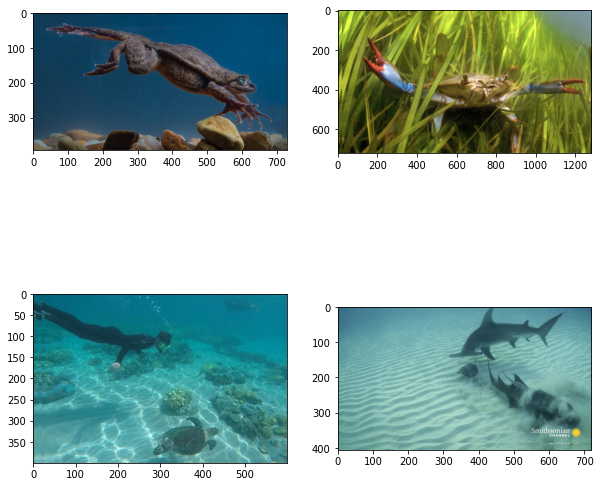

In [ ]:
# Visualization of augmentations.
transform = T.ToPILImage()
images ={}
image = transform(images_train[593])
image.resize((256,256))
images[0] = image

image = transform(images_train[742])
image.resize((256,256))
images[1] = image

image = transform(images_train[800])
image.resize((256,256))
images[2] = image

image = transform(images_train[1000])
image.resize((256,256))
images[3] = image


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
count = 0
for i in range(2):
    for j in range(2):        
        if count < len(images):
            axes[i, j].imshow(images[count])
            count+=1

### Creating custom dataset class for dataloaders.

In [ ]:
class myDataset(Dataset):
    def __init__(self,input_data,mask,transform, transform_label):
        self.input=input_data
        self.mask = mask
        self.transforms = transform
        self.transforms_label = transform_label


    def __len__(self):
        return len(self.input)

    def __getitem__(self, index):
        x=self.input[index]
        z=self.mask[index]
#         print(x,z)
        if self.transforms is not None:
            # apply the transformations to both image and its mask
            x = self.transforms(x)
            z = self.transforms_label(z)
            z = torch.tensor(np.asarray(z))
            #class number 31 = other class is labelled as 0 in dataloader.
            z[z == 31] = 0
        return x,z

#class for hyperparameters.
class hyperparam:
    num_classes=31
    num_workers=5
    bs=20
    epochs = 200
    HEIGHT= 256
    WIDTH = 256

### Performing transforms on data and creation of dataloaders.

In [ ]:
from torchvision import transforms
import torchvision.transforms.functional as F
from torchvision.transforms import InterpolationMode as interpolate

transforms_image = transforms.Compose([transforms.ToPILImage(),transforms.Resize((hyperparam.HEIGHT,hyperparam.WIDTH)),transforms.ToTensor(),transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])])
transforms_label = transforms.Compose([transforms.ToPILImage(),transforms.Resize((256,256), interpolate.NEAREST)])
#, transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])

training_set = myDataset(images_train,masks_train,transforms_image,transforms_label)
test_set = myDataset(images_test,masks_test,transforms_image,transforms_label)
# final_test_set = myDataset(images_test,masks_test,transforms_image,transforms_label)

train_gen = DataLoader(training_set,shuffle=True,batch_size=hyperparam.bs, pin_memory=False,num_workers=os.cpu_count())
test_gen = DataLoader(test_set,shuffle=False,batch_size=hyperparam.bs, pin_memory=False,num_workers=os.cpu_count())

# final_test_gen = DataLoader(final_test_set,shuffle=False,batch_size=1, pin_memory=False,num_workers=os.cpu_count())

### Creating model

In [ ]:
#Source for the class fcn_resnet50: https://pytorch.org/vision/main/_modules/torchvision/models/segmentation/
"""
The class returns dense prediction sof size 32*32 with 512 channels at the output head. We have upsampled this prediction to 256*256 with 31 output channels.
The Fully convolutional neural network in torchivsion is implemented according to below paper
Long, J., Shelhamer, E., & Darrell, T. (2015). Fully Convolutional Networks for Semantic  Segmentation. https://arxiv.org/abs/1411.4038
"""
class MyFCN(nn.Module):
    def __init__(self, num_classes, 
                 pretrained=True, 
                 criterion=nn.CrossEntropyLoss(ignore_index=255),
                 network_name='resnet50',
                 training=False):                    
        super(MyFCN, self).__init__()
        
        self.num_classes   = num_classes
        self.criterion     = criterion
        self.backbone_name = network_name
        self.training      = training        
        
        if pretrained:
            net = fcn_resnet50(pretrained=pretrained,                             
                            pretrained_backbone= True)
                            
                
        #self.classifier = nn.Sequential(*[net.classifier[i] for i in range(5)])
        
        self.backbone   = net.backbone
        self.classifier = nn.Sequential(*list(net.classifier.children())[:-1])        
#         self.last_layer = nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1))
#         self.upsample1 = nn.ConvTranspose2d(num_classes, num_classes, (4,4), stride=4)
#         self.upsample2 = nn.ConvTranspose2d(num_classes, num_classes, (2,2), stride=2)
        """
        We have upsampled the output of the model to 256*256 to match the ground truth size. 
        Below git repo was reffered for the same.
        https://github.com/pochih/FCN-pytorch/blob/master/python/fcn.py
        """
        self.relu    = nn.ReLU(inplace=True)
        self.bn1     = nn.BatchNorm2d(512)
        self.bn2     = nn.BatchNorm2d(256)
        self.bn3     = nn.BatchNorm2d(128)
        self.bn4     = nn.BatchNorm2d(64)
        self.bn5     = nn.BatchNorm2d(32)
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=1, stride=1, padding=0, dilation=1, output_padding=0)
        self.final = nn.Conv2d(32, num_classes, kernel_size=1)
        
        '''if self.training:
            self.aux_classifier = nn.Sequential(*list(net.aux_classifier.children())[:-1])        
            self.aux_last_layer = nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1))
            '''

        
    def forward(self, x):
        
        x = self.backbone(x)
        x = x['out'] # the other key in the ordered dictionary is 'aux'
        #pdb.set_trace()
        x = self.classifier(x)
    
        score = self.relu(self.deconv2(self.bn1(x)))      # size=(2, 256, x.H/4, x.W/4)
        score = self.bn2(score) 
        score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 128, x.H/2, x.W/2)
        score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
        score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
        score = self.final(score)                         # size=(N, n_class, x.H/1, x.W/1)

        """
        ----------- End of reffered code --------------
        """


        return score            


In [ ]:
model = MyFCN(num_classes = 31)

Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth


  0%|          | 0.00/135M [00:00<?, ?B/s]

### Defining loss function an optimizers

In [ ]:
lossfunc = nn.CrossEntropyLoss()
# lossfunc = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.0001)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor = 0.0001)


### Creating dictionary of classes

In [ ]:
classes = ["other","crab","crocodile","dolphin","frog","nettles","octopus","otter","penguin","polar_bear","sea_anemone","sea_urchin","seahorse","seal","shark","shrimp","star_fish","stingray","squid","turtle","whale","nudibranch","coral","rock","water","sand","plant","human","iceberg","reef","fish"]

sem_class_to_idx = {cls: idx for (idx,cls) in enumerate(classes)}


### Setting device as GPU if available and CPU otherwise.

In [ ]:
torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Function used to train the model

In [ ]:

def training(model): 
    model.to(device)
    temp_train = 0
    training_loss=0
    model.train(True)
#     print("here")
    with torch.set_grad_enabled(True):
#     print("here1")
        for batch,labels in train_gen:
    #             print("here2")
            batch=batch.float().to(device)
    #             print("batch size", batch.size())
    #             print(batch,label)

            predictions=model(batch)
            npred = torch.softmax(predictions,dim=1)
#             print("npred.requires_grad",npred.requires_grad)
            labels = labels.squeeze(1).to(device)
            pred_loss = lossfunc(npred.float(),labels.long()) 
#             print("pred_loss",pred_loss)
            temp_train  += pred_loss * hyperparam.bs
#             print(pred_loss)
#             print("pred_loss",pred_loss)
            optimizer.zero_grad()
            pred_loss.backward()
            optimizer.step()
#             print("pred_loss",pred_loss)
        
    training_loss = temp_train / len(train_gen.dataset)
    print("Training avg loss = ",training_loss)
    return training_loss

### Function used to validate the model

In [ ]:

def validate(model):
    testing_avg_loss=0
    testing_loss=0
    model.to(device)
#     print("here")
    with torch.set_grad_enabled(False):
        model.eval()
#         print("here1")
        for batch,labels in test_gen:
    #             print("here2")
            batch=batch.float().to(device)
            predictions=model(batch)
            npred = torch.softmax(predictions,dim=1)
            labels = labels.squeeze(1).to(device)
            pred_loss = lossfunc(npred.float(),labels.long()) 
            testing_loss += pred_loss * hyperparam.bs
            
        testing_avg_loss = testing_loss/len(test_gen.dataset)
        print("Test avg loss = ",testing_avg_loss)
        return testing_avg_loss


### Functions to find mIOU metric and accuracy value. <br>
We reffered the implementation of these metrics for semantic segmentation from the following links. <br>
https://github.com/mseg-dataset/mseg-semantic<br>
https://github.com/mseg-dataset/mseg-semantic/tree/master/mseg_semantic/utils<br>

In [ ]:
def Calculate_mIOU(output,target):
    #flatten the tensor to 1-D arrays
    k=31
    output = output.flatten().clone()
    target = target.flatten()
    intersection = output[np.where(output == target)[0]]
    area_intersection, _ = np.histogram(intersection,bins=np.arange(k+1))
    area_output,_=np.histogram(output,bins=np.arange(k+1))
    area_target,_=np.histogram(target,bins=np.arange(k+1))
    area_union=area_output+area_target-area_intersection
    return area_intersection,area_union,area_target

In [ ]:
class calculate():
    def __init__(self):
        self.intersection_sum=0
        self.union_sum=0
        self.target_sum=0
        self.count=0
    def add(self,output,target):
        area_intersection,area_union,area_target=Calculate_mIOU(output,target)
        self.intersection_sum+=area_intersection
        self.union_sum+=area_union
        self.target_sum+=area_target
        self.count+=1
    def calculate_accuracy(self):
        accuracy= sum(self.intersection_sum)/sum(self.target_sum + 1e-10)
        maccuracy=np.mean(self.intersection_sum/(self.target_sum + 1e-10))
        iou = self.intersection_sum/(self.union_sum + 1e-10)
        miou=np.mean(iou)
        return miou,maccuracy,accuracy

### Training and validation of the model.<br>
All the losses are stored in lists used to plot the loss in a graph later.

In [ ]:
training_all_loss = []
validation_all_loss = []
for epochs in range(hyperparam.epochs):
    t_avg_loss = training(model)
    training_all_loss.append(t_avg_loss.cpu().detach().numpy())
    
    d_avg_loss = validate(model)
    validation_all_loss.append(d_avg_loss.cpu().detach().numpy())
    # scheduler.step(d_avg_loss)
torch.save(model,'mymodel5.pth')

Training avg loss =  tensor(3.3783, device='cuda:0', grad_fn=<DivBackward0>)
Test avg loss =  tensor(3.4355, device='cuda:0')
Training avg loss =  tensor(3.2810, device='cuda:0', grad_fn=<DivBackward0>)
Test avg loss =  tensor(3.3465, device='cuda:0')
Training avg loss =  tensor(3.2189, device='cuda:0', grad_fn=<DivBackward0>)
Test avg loss =  tensor(3.2728, device='cuda:0')
Training avg loss =  tensor(3.1694, device='cuda:0', grad_fn=<DivBackward0>)
Test avg loss =  tensor(3.2688, device='cuda:0')
Training avg loss =  tensor(3.1312, device='cuda:0', grad_fn=<DivBackward0>)
Test avg loss =  tensor(3.2412, device='cuda:0')
Training avg loss =  tensor(3.0988, device='cuda:0', grad_fn=<DivBackward0>)
Test avg loss =  tensor(3.2026, device='cuda:0')
Training avg loss =  tensor(3.0697, device='cuda:0', grad_fn=<DivBackward0>)
Test avg loss =  tensor(3.1998, device='cuda:0')
Training avg loss =  tensor(3.0395, device='cuda:0', grad_fn=<DivBackward0>)
Test avg loss =  tensor(3.1721, device='c

Visualization of Training and validation loss.

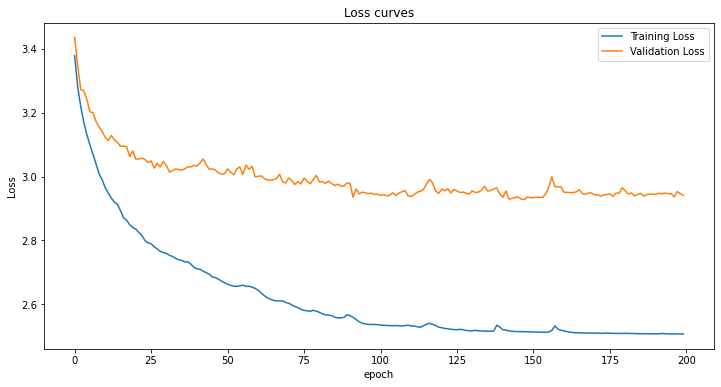

In [ ]:
plt.figure(figsize = (12,6))
plt.plot(range(len(training_all_loss)),training_all_loss)
plt.plot(range(len(validation_all_loss)),validation_all_loss)
plt.legend(["Training Loss", "Validation Loss"])
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.title('Loss curves')
plt.show()


### Calculation of training and testing metrics: 
mIOU = mean Intersection over union<br>
maccuracy = mean accuracy of all classes<br>
Accuracy<br>

In [ ]:

import torchvision.transforms as T

        
def calculate_metrics(model):

    cal_metrics=calculate()
    model.to(device)
#     print("here")
    with torch.set_grad_enabled(False):
        model.eval()
#         print("here1")
        count=0
        for batch,labels in train_gen:
    #             print("here2")
            count+=1
            batch=batch.float().to(device)
            predictions=model(batch)
            predicted_masks=torch.argmax(predictions,dim=1).type(torch.float)
            labels = labels.squeeze(1).to(device)
            cal_metrics.add(predicted_masks.cpu(),labels.cpu()) 
        print("Training set: miou,maccuracy,accuracy: ",cal_metrics.calculate_accuracy())

    cal_metrics_=calculate()
    with torch.set_grad_enabled(False):
        model.eval()
#         print("here1")
        count=0
        for batch,labels in test_gen:
    #             print("here2")
            count+=1
            batch=batch.float().to(device)
            predictions=model(batch)
            predicted_masks=torch.argmax(predictions,dim=1).type(torch.float)
            labels = labels.squeeze(1).to(device)
            cal_metrics_.add(predicted_masks.cpu(),labels.cpu()) 
        print("Testing set: miou,maccuracy,accuracy: ",cal_metrics_.calculate_accuracy())

calculate_metrics(model)

Training set: miou,maccuracy,accuracy:  (0.9699386894660507, 0.985810677892754, 0.9890053799457601)
Testing set: miou,maccuracy,accuracy:  (0.33179398969782653, 0.4683179964446413, 0.6459137489055761)


### Testing Phase

We predicted the segmentation masks using our trained model.

In [ ]:
import torchvision.transforms.functional as F

testing_total_loss=0
testing_loss=0
model.to(device)
model.eval()
print("here")
All_predicted_test_masks = []
with torch.set_grad_enabled(False):
    print("here1")
    for batch,labels in test_gen:
#             print("here2")
        batch=batch.float().to(device)
        labels=labels.float()
        predictions=model(batch)
        predictions = predictions.type(torch.FloatTensor)
        npred = torch.argmax(predictions,dim=1)
        All_predicted_test_masks.append((batch,labels,npred))

### Visualization of outputs.

Pallete to visualize 31 different classes

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
palette = np.array([[128,128,128],   # gray 0 other
                    [255,69,0],      # orange 1 crab
                    [0,100,0],       # green 2 crocodile
                    [255,0,0],       # red 3  dolphin
                    [128,0,128],     # purple 4 frog
                    [0,0,255],       # blue 5 nettles
                    [255,0,255],     # Magenta 6 octopus
                    [255,255,0],     # Yellow 7 otter
                    [0,255,255],     # Cyan 8 penguin
                    [128,0,0],       # maroon 9 polar_bear
                    [255,20,147],    # deep pink 10 sea_anemone
                    [139,69,19],     # saddle brown 11 sea_urchin
                    [0,128,128],     # Teal 12  seahorse
                    [128,128,0],     # Olive 13 seal
                    [218,165,32],    # golden 14  shark
                    [188,143,143],   # rosy brown 15 shrimp 
                    [64,224,208],    # turquoise 16 star_fish
                    [95,158,160],    # cadet blue 17 stingray
                    [219,112,147],   # Pale Violet Red 18 squid
                    [216,191,216],   # thistle 19 turtle
                    [189,183,107],   # dark khaki 20 whale
                    [135,206,250],   # light sky blue 21 nudibranch
                    [255,127,80],    # coral 22 coral
                    [192,192,192],   # silver 23 rock
                    [240,255,255],   # azure 24 water
                    [244,164,96],    # sandy brown 25 sand
                    [124,252,0],     # lawn green 26 plant
                    [255,228,181],   # moccasin 27 human
                    [176,196,222],   # light steel blue 28 ice berg
                    [75,0,130],      # indigo 29 reef
                    [ 0, 0, 0]       # Black 30 fish          
                    ])

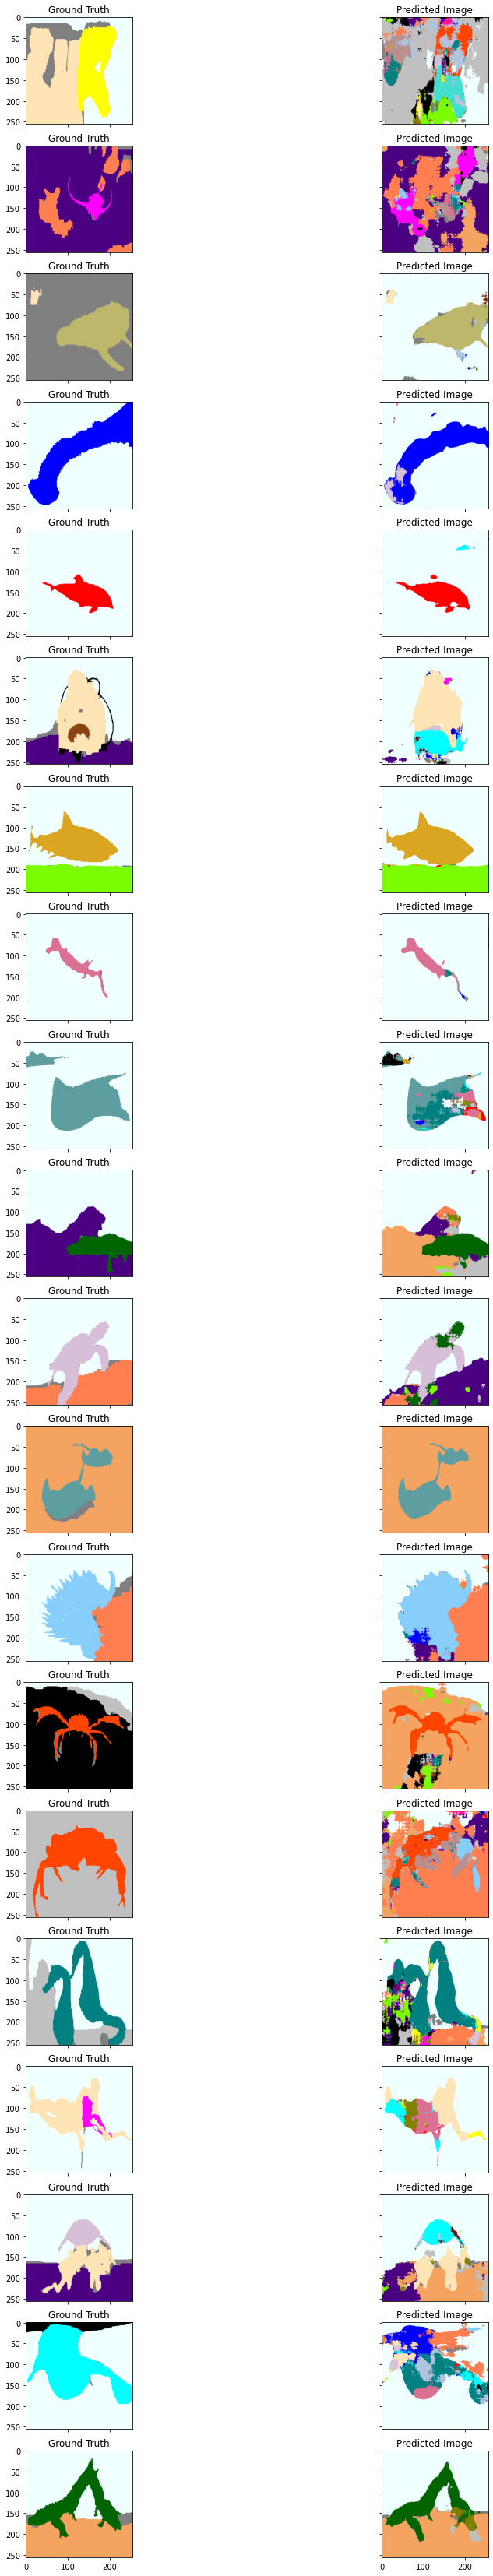

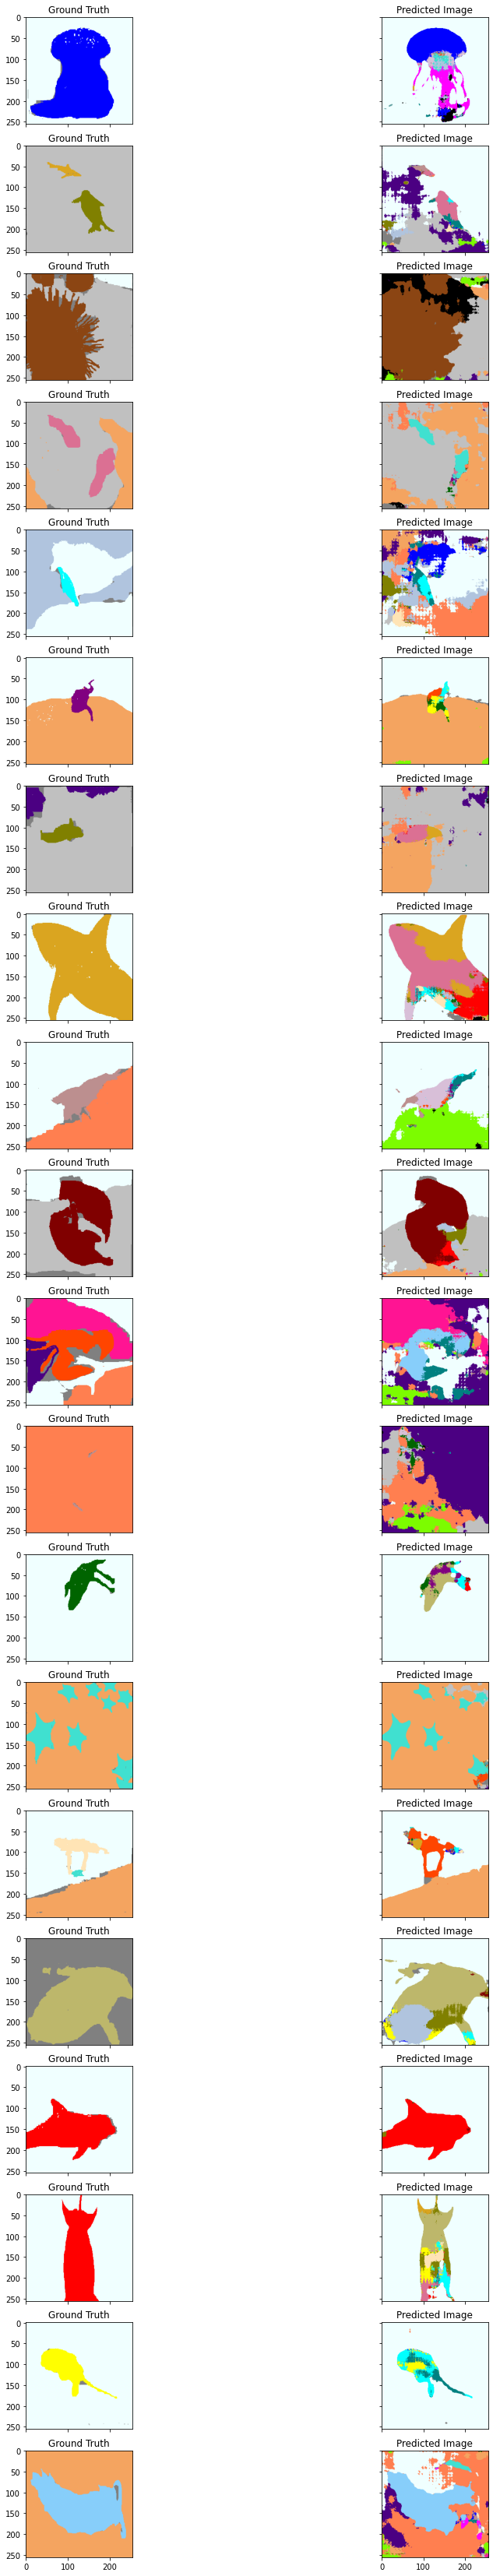

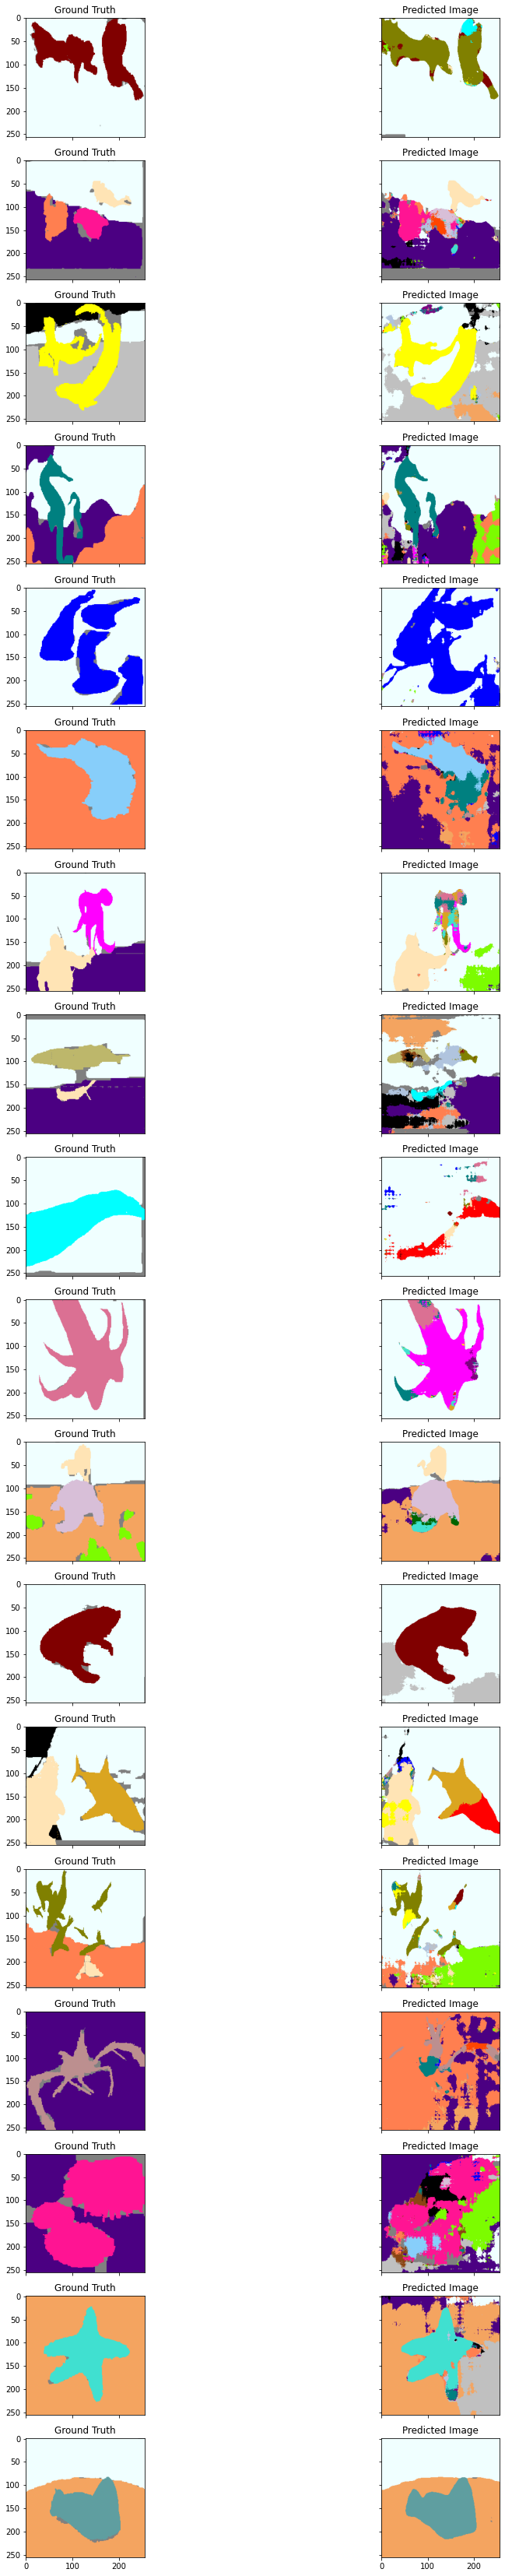

In [ ]:
def show(labels,npred,Image_number):

    cmap=matplotlib.cm.spring
    # print(len(npred))
    fix, axs = plt.subplots(nrows = len(npred) ,ncols=2,sharex=True, sharey=True, squeeze=False, figsize=(15,60))

    # fix.tight_layout()
    for i in range(len(npred)):
        #print(len(mask.detach().numpy()))
        #print(mask.detach().numpy().size())
        mask=npred[i].detach().numpy()
        gt=labels[i].detach().numpy()
        axs[i,0].set_title("Ground Truth")
        RGB = palette[gt.astype(np.int32)]
        axs[i, 0].imshow(RGB)
        axs[i,1].set_title("Predicted Image")
        RGB = palette[mask.astype(np.int32)]
        axs[i,1].imshow(RGB)
        

Image_num = 0
for batch,labels,npred in All_predicted_test_masks:
    show(labels,npred,Image_num)

Other links we reffered <br>
https://pytorch.org/vision/stable/generated/torchvision.models.segmentation.fcn_resnet50.html#torchvision.models.segmentation.fcn_resnet50<br>
https://pytorch.org/vision/stable/auto_examples/plot_visualization_utils.html#sphx-glr-auto-examples-plot-visualization-utils-py